In [1]:
import os

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from new_cls_eegdatasets import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


label_tensor torch.Size([16540])
Data tensor shape: torch.Size([16540, 17, 100]), label tensor shape: torch.Size([16540]), text length: 1654, image length: 16540
extracted_data shape: torch.Size([16540, 17, 51])
label_tensor torch.Size([2000])
Data tensor shape: torch.Size([2000, 17, 100]), label tensor shape: torch.Size([2000]), text length: 200, image length: 200
extracted_data shape: torch.Size([2000, 17, 51])


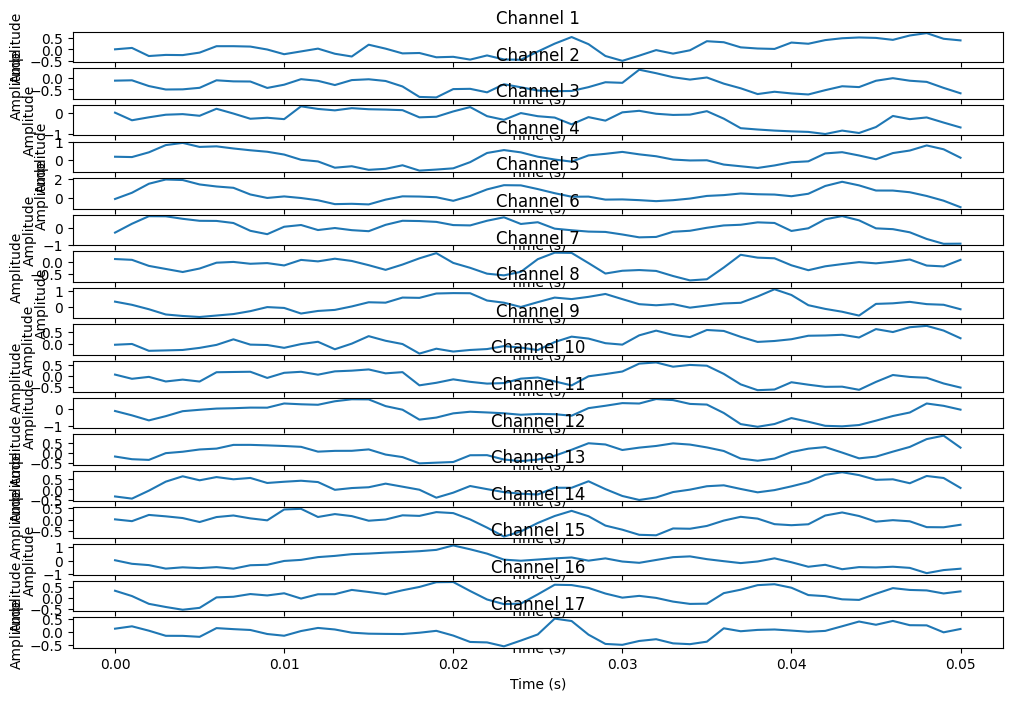

In [3]:
config = {
"data_path": "/home/ldy/Workspace/THINGS/EEG/osfstorage-archive",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 512,
"logger": True
}

# with open('config.json', 'r') as f:
#     config = json.load(f)

# 获取数据路径
data_path = config['data_path']
train_dataset = EEGDataset(data_path, train=True)
test_dataset = EEGDataset(data_path, train=False)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=0, drop_last=True)

for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(train_loader):
    # Number of channels
    eeg_data = eeg_data[0]
    num_channels = eeg_data.shape[0]

    # Create a time axis (assuming a constant sampling rate)
    # Replace '1000' with your actual sampling rate if different
    time_axis = torch.arange(0, eeg_data.shape[1]) / 1000.0  

    plt.figure(figsize=(12, 8))

    # Plot each channel
    for i in range(num_channels):
        plt.subplot(num_channels, 1, i + 1)
        plt.plot(time_axis, eeg_data[i].numpy())
        plt.title(f'Channel {i+1}')
        plt.ylabel('Amplitude')
        plt.xlabel('Time (s)')

    plt.tight_layout()
    plt.show()
    # print(eeg_data.shape)
    break